
   <h1><center>Qatar Airways Infotainment System Pitch - Movie Recommender System</center></h1>

   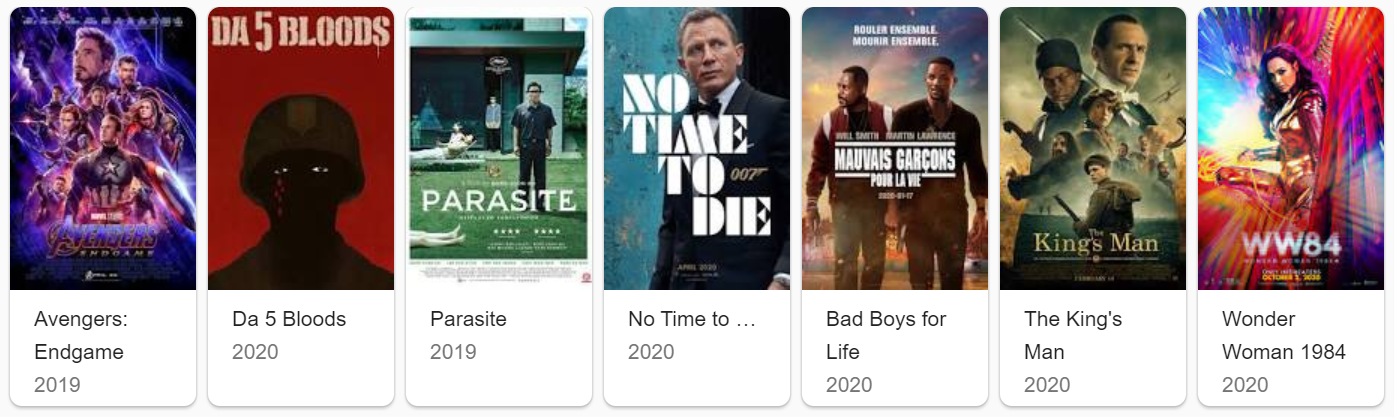 

<h2>Background Information of Recommender System</h2>

A recommendation system is a subclass of Information filtering Systems that seeks to predict the rating or the preference a user might give to an item. In simple words, it is an algorithm that suggests relevant items to users.Hence in today’s world which is driven by technology and the 4th Industrial Revolution, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options

<h2>Project Brief and Problem Statement</h2>

With the backgorund information on recommender system, what is required is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.



<a id="cont"></a>

## Table of Contents

1. Importing Packages

2. Loading Data

3. Data information and description

4. Exploratory Data Analysis (EDA)

5. Data Preprocessing and Engineering 

6. Modeling 

   6.1 Content-based Recommender

   6.2 Collaborative Recommender

   6.3 Hybrid Recommender


# 1. Importing Packages


In [22]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud, STOPWORDS

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import tqdm as tq

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import sklearn
import pickle   


Run the cell below if you want to run the PCA code...

In [4]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# 2. Loading the Data


In [2]:
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# 3. Data Infromation and description

In [3]:
genome_scores.isnull().sum()
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [4]:
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [5]:
imdb_data.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [6]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [7]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
test.isnull().sum()

Unnamed: 0           0
movieId              0
title                0
genres               0
title_cast       47453
director         47076
runtime              0
budget               0
plot_keywords    48181
soup                 0
year                 0
dtype: int64

In [10]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
joined_table = train.merge(movies, how='left', on='movieId')

In [14]:
joined_table.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [3]:
joined_table2 = movies.merge(imdb_data, how='left', on='movieId')
joined_table2.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [5]:
movie_genre = pd.DataFrame(joined_table2[['movieId', 'genres']], columns=['movieId', 'genres'])
movie_genre['genres'] = movie_genre['genres'].apply(lambda x: x.split('|'))

movie_genre = pd.DataFrame([(tup.movieId, d) for tup in movie_genre.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movie_genre.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy



# 4. Exploratory Data Analysis (EDA)

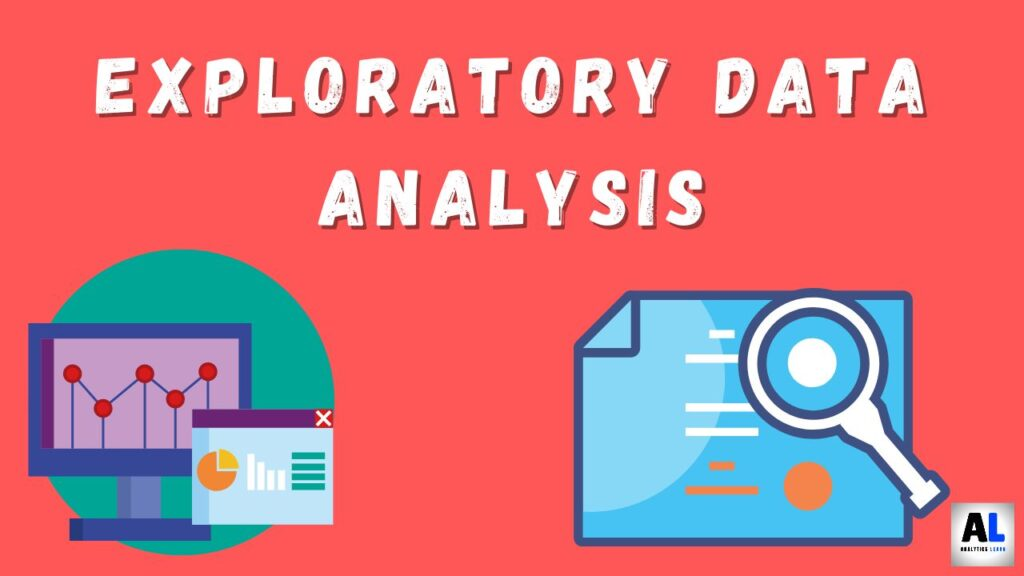

### Most common generes

Drama is the most commonly occurring genre with almost half the movies identifying itself as a drama film. Comedy comes in at a distant second. Other major genres represented are Action, Horror, Crime, Mystery, Science Fiction, Animation and Fantasy.

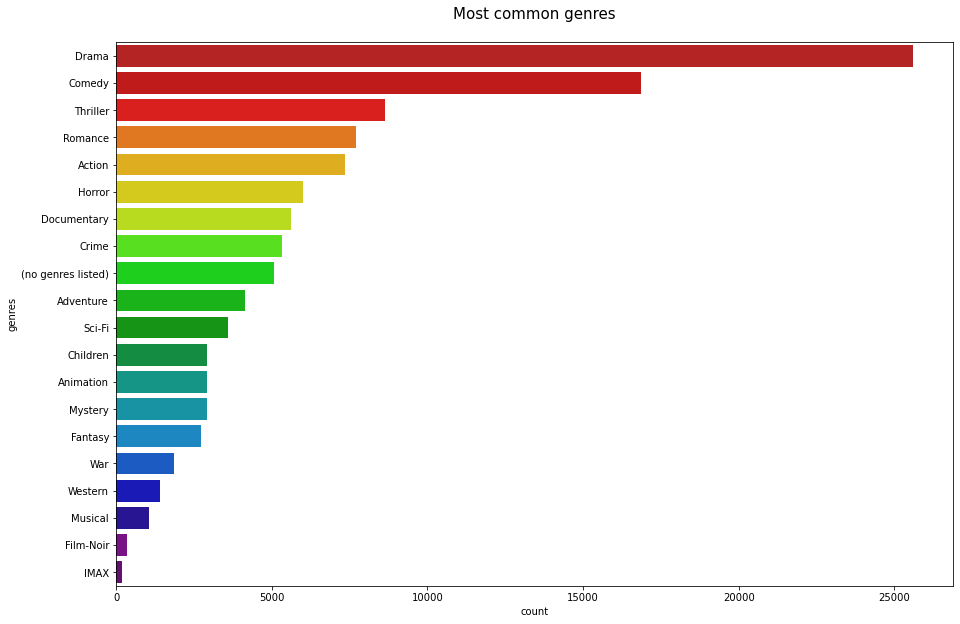

In [6]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=15)
sns.countplot(y="genres", data=movie_genre,
              order=movie_genre['genres'].value_counts(ascending=False).index,
              palette="nipy_spectral_r")
plt.show()

<h5>EDA Analysis:</h5>

From this horizontal bar chart it can be noted that the drama genre is the one with the higest count which considerng the words in the word cloud related to human sexuality it make sense and there is some sort of correlation. Comedy comes in second with about 17 000 counts which might suggest that people like watching less serious movies almost as much as they like watching dramas. At the bottom we can see movies generes like IMAX which is uncommon probably because these are niche movies with limited releases. There are generes like Film-Noir which consist of darker crime dramas and the 1940-1950s events which makes sense that people of today won't be interest in such movies.

### Top Movie Directors

In [8]:
joined2 = movies.merge(imdb_data,  how='left', on = 'movieId')

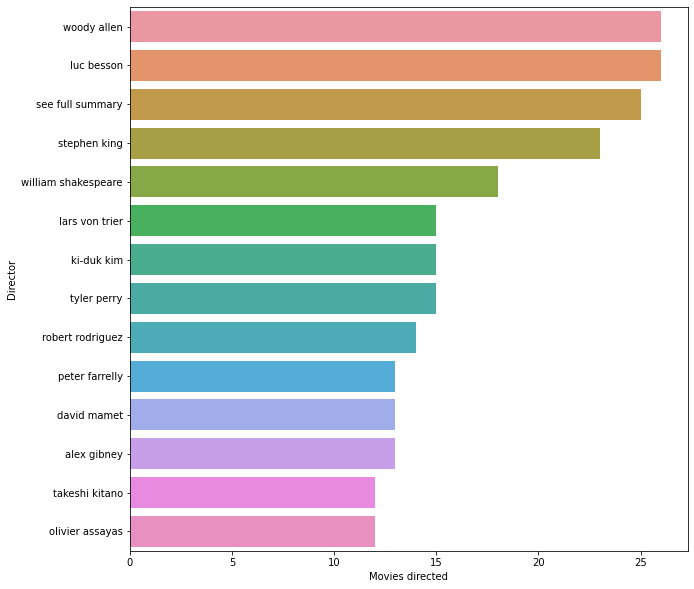

In [9]:
joined2['director'] = joined2['director'].str.lower()
joined2['director'] = joined2['director'].astype(str)
directors = '|'.join([text for text in joined2['director']])

plt.rcParams['figure.figsize'] = [10, 10]
freq_dist = nltk.FreqDist(directors.split('|'))
df = pd.DataFrame({'Director': list(freq_dist.keys()),
                  'Movies directed' : list(freq_dist.values())})

df = df.nlargest(columns='Movies directed', n=15).iloc[1:]

ax = sns.barplot(data=df, y='Director', x='Movies directed')
plt.show()

<h5>EDA Analysis:</h5>

This section show various directors and the number of movies that they have directed, Woody Allen is the most prominent director featured in the dataset. this is followed by Luc Besson, a French director.

### Top Actors 

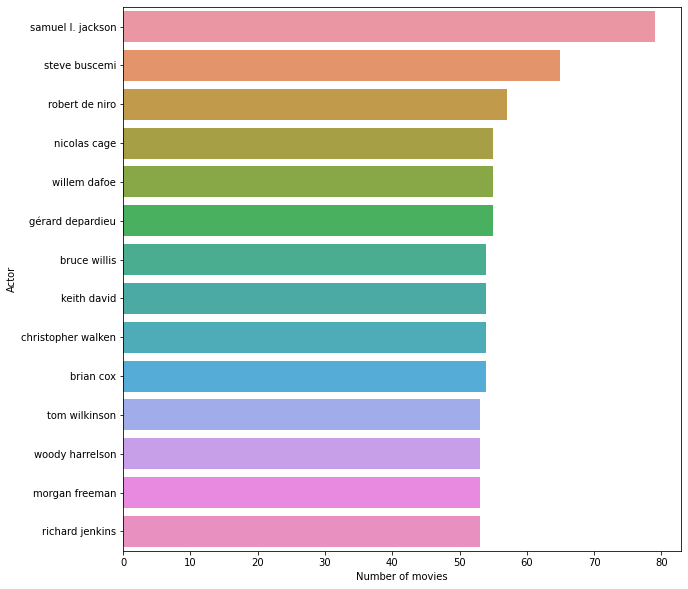

In [10]:
joined2['title_cast'] = joined2['title_cast'].str.lower()
joined2['title_cast'] = joined2['title_cast'].astype(str)
cast = '|'.join([text for text in joined2['title_cast']])

plt.rcParams['figure.figsize'] = [10, 10]
# plt.subplot(1, 4, i + 1)
freq_dist = nltk.FreqDist(cast.split('|'))
df = pd.DataFrame({'Actor': list(freq_dist.keys()),
                  'Number of movies' : list(freq_dist.values())})

df = df.nlargest(columns='Number of movies', n=15).iloc[1:]

ax = sns.barplot(data=df, y='Actor', x='Number of movies')
plt.show()

<h5>EDA Analysis:</h5>

This bar chart gives insight in terms of the actors who have appeared in most movies, we can see that the top three is dominate by famous actors Samuel L Jackson, Steve Buscemi, and Robert De Niro which are big names in the industry. However it should be noted that these counts will include roles where actors were not one of the top billed cast for a particular movie as well.

### Word Cloud with Key Words 

---

(-0.5, 999.5, 399.5, -0.5)

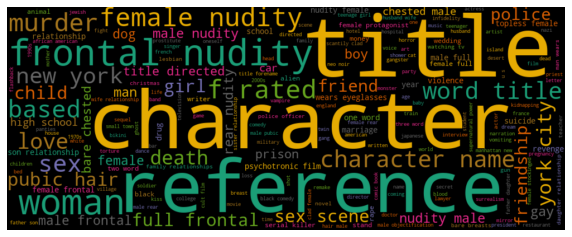

In [11]:
joined2['plot_keywords'] = joined2['plot_keywords'].str.lower()
joined2['plot_keywords'] = joined2['plot_keywords'].astype(str)
genres = '|'.join([text for text in joined2['plot_keywords'] if not text == 'nan'])

wc = WordCloud(width=1000, height=400, 
               background_color='black', colormap='Dark2',
               max_font_size=150, random_state=42)
wc.generate(genres)
# plt.subplot(2, 2, i + 1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.title(full_title[i])

<h5>EDA Analysis:</h5> 

As word clouds shows prominence of text data, it can been seen from this particular word cloud that there are generic word such as character, title and reference which stand out, but when we look more into words which might be unique for movies there is an emphasis on words related to sexuality:Woman, Nudity, Sex, Girl, Man etc. Another aspect of these word one is there is one unique location which stands out (York City) which most likely is refering to New York City

### Movie Ratings 

<AxesSubplot:>

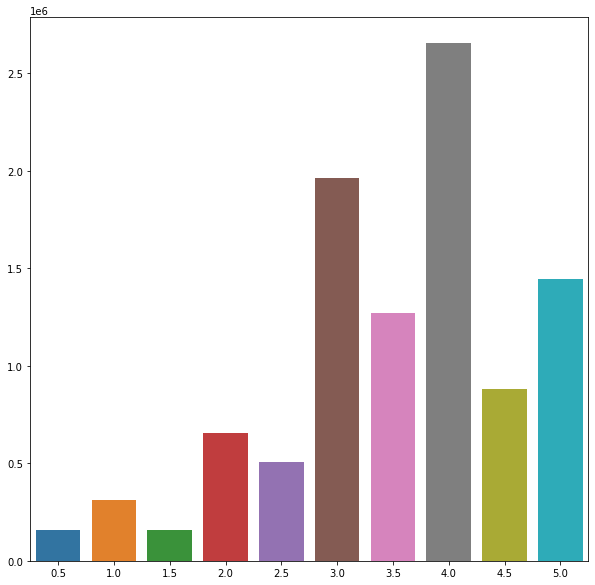

In [12]:
ratings=train['rating'].value_counts()

sns.barplot(ratings.index, ratings.values)

<h5>EDA Analysis:</h5>

The movie rating bargraph gives an inidication of the user's experience with various movies that they have watched. What can be deduced here is that there is a few movies which have lower ratings which are between 0.5 - 2.5, such might be due to the fact that a user watches a movie and becomes uninterested in rating the moive either because the movie wasn't good or they just find it tedious to rate movies. So from the user who rated the various moives it can be seen that the most count is a rating of 4, it is highly unlikely for people to numbers with decimals such as 3.5 and 4.5 hence it makes sense why the rating of 4 seems more common.

In [15]:
joined_table = train.merge(movies, how='left', on='movieId')

In [16]:
joined_table2 = joined_table.merge(imdb_data, how='left', on='movieId')
joined_table2.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...


<AxesSubplot:ylabel='Frequency'>

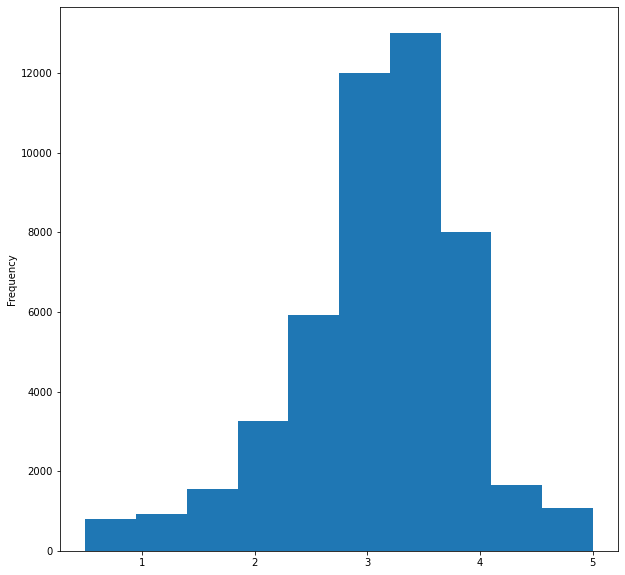

In [17]:
rankings = joined_table2[['rating','title']].groupby('title').mean().sort_values('rating', ascending=False)
rankings ['num_ratings']= joined_table2.groupby('title')['rating'].count()
new = rankings.sort_values(by=['num_ratings', 'rating'], ascending=False).head()
norm = train.groupby('movieId')['rating'].mean()

norm.plot(kind='hist')

<AxesSubplot:xlabel='rating', ylabel='num_ratings'>

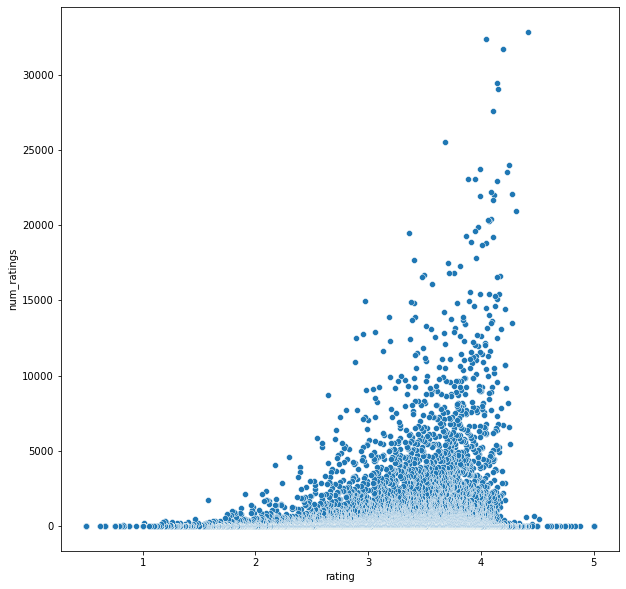

In [18]:
sns.scatterplot(data=rankings, x='rating', y='num_ratings')

<h5>EDA Analyis:</h5>

The scatter plot above give indication of the relationship between the number of ratings that a movie received that the rating it received was between 0.5 - 5 stars. So it must be noted as can be seen in the movie ratings bar graph that the ratings of the movie start from 0.5 and not hence when we look at the scatter plot there is no zero-rated movies.

In [19]:
del joined_table, joined_table2

# 5. Data Preprocessing and  Engineering


Prior to training a model with any sort of data, it is essential to re-engineer it. This is to ensure that the data is in a consistent form with no missing values, incorrect data types or just plain incorrect data. For structured,  numeric data, this entails scaling values, filling in missing values and typecasting any non-numeric data to numeric form. Non-numeric data, such as this database is often unstructured and consists of text data. This type of data is not easily interpretable by computers. Computers work with 1s and 0s, not letters and words. Therefore it must be converted into a form that is interpretable: numeric data. 

---
First thing, we need to merge the movies dataframe with the imdb_data dataframe, these two dataframes contain most of the information we need to construct our recommender.

As you can see, for each movie we now have multiple columns that contain useful information about each movie:
* genres
* title_cast
* director
* plot_keywords

There are more columns that could be useful, such as budget, but lets stick to these for now.

In [3]:
joined2 = movies.merge(imdb_data,  how='left', on = 'movieId')
joined2.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


There is a lot of actors names for each movie in the title_cast column! Since we're going to ultimately be vectorizing all of this data, we should ask ourselves if we really need all the actors for each movie listed in this column. For the sake of minimizing the number of features in our vectorized dataset, lets reduce this to the top 3 actors. The first 3 actors in this column seem to be the top-billed/most prominent cast for each film, so it's likely that they're the most important anyway.

In [4]:
def first_3(actors):
  s = []
  s = [actor for actor in actors if len(s) < 3]
  s2 = s[:3]
  return '|'.join([actor for actor in s2])

# x = ['Rhys Ifans', 'Tim Allen', 'Don Rickles', 'Crispin Glover', 'Christian McKay']
# print(first_3(x))


joined2['title_cast'] = joined2['title_cast'].apply(lambda x: str(x).split('|'))
joined2['title_cast'] = joined2['title_cast'].apply(first_3)
joined2.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


One problem with this dataset are the number of nan values. Most of these are actual np.nan null values, however some of them are actually 'nan' strings. Sneaky! We'll need to convert all these cryptic nan values to real nan values and then impute something whenever they occur, since null values cannot be passed to a vectorizer.

In [5]:
def check_nan(field):
  '''Some NaN values are being stored as strings, so fillna wont work'''
  if not isinstance(field, str):
    return np.nan
  f2 = field.strip().lower()
  if 'nan' in f2:
    return np.nan
  else:
    return field

joined3 = joined2.copy()
joined3['title_cast'] = joined3['title_cast'].apply(check_nan)
joined3['plot_keywords'] = joined3['plot_keywords'].apply(check_nan)

Lets replace all nan values with empty strings. This means that there will be a lot of movies with a lot of empty metadata columns, but hopefully when we include the genome tag dataset this will become less of an issue.

In [6]:
joined3['director'].fillna('', inplace = True)
joined3['title_cast'].fillna('', inplace = True)
joined3['runtime'].fillna(0, inplace = True)
joined3['budget'].fillna(0, inplace = True)
joined3['plot_keywords'].fillna('', inplace = True)

Creating a word soup column. This column has all the text data in it that we will vectorize. Think of all the words/names in these columns becoming tags. We've added director 3 times so that it has more weighting. IE, if someone likes a movie like Inception, then they are likely to enjoy other movies directed by Christopher Nolan. This is quite a hacky way of altering the weightings of specific tags, but creating a word soup like this does simplify the vectorizing process.

In [7]:
joined3['soup'] = joined3['genres'] + '|' + joined3['director'] + '|' + joined3['director'] + '|' + joined3['director'] + '|' + joined3['plot_keywords'] + '|'+ joined3['title_cast']
joined3.iloc[1]

movieId                                                          2
title                                               Jumanji (1995)
genres                                  Adventure|Children|Fantasy
title_cast              Robin Williams|Jonathan Hyde|Kirsten Dunst
director                                        Jonathan Hensleigh
runtime                                                      104.0
budget                                                 $65,000,000
plot_keywords                     board game|adventurer|fight|game
soup             Adventure|Children|Fantasy|Jonathan Hensleigh|...
Name: 1, dtype: object

The movie titles contain their release year. We'll leave those in to keep things compatible with the streamlit app. But we'll also add the years to their own column. Just in case we decide to use this information

In [8]:
def get_year(title):
  s = title.split()
  year = s[-1]
  if '(' in year and ')' in year:
    year2 = year[1:-1]
    return year2
  else:
    return np.nan
  
joined3['year'] = joined3['title'].apply(get_year)

Filling in nan values in the year column with 0 

In [9]:
joined3['year'].fillna('0', inplace = True)

#### What to do about the genome tag data?

---
The genome tag data consists of 1128 tags assigned to the movies in the movie database. What is handy about this data is that there are no null values. 1128 standardized tags used across all movies is also useful for the purposes of vectorization, at most, we'll only be adding 1128 new features. This is very efficient considering how much data there is! One other thing, each tag for each movie is assigned a relevance value. Values closer to zero mean that particular tag is not related to that movie, a relevance closer to 1 means that a tag is related to a movie.

---
How would we add these tags to our word soup data while also accounting for the extra data contained in the relevance column? The option we've gone for here is again quite hacky, tags with a relevance >= 0.5 will be added to a particular movie's word soup once, while tags with a relevance >= 0.8 will be added twice, thus increasing their weighting in the same way adding the director of a movie multiple times to its word soup increases weighting.

---
Word of warning, we could not find a straightforward way to write this code more efficiently, on a relatively new laptop with an 11th gen i5 processer the cell below takes 2h30m to run. Fortunately, it only needs to be run once.

Use the code located 3 cells below thats been commented out to import the output dataframe and save yourself 2h30m of your life :)

In [ ]:
%%time
def get_genome_tags(movieid):
    scores = genome_scores.loc[genome_scores['movieId'] == movieid]
    output = []
    output2 = ''
    for index, row in scores.iterrows(): # itering through a dataframe is heresy but we're taking the janky route here
        tag = genome_tags.loc[genome_tags['tagId'] == row['tagId']].values[0][1]
        relevance = row['relevance']
        if relevance >= 0.5:
            output += [tag]
        if relevance >= 0.80:
            output += [tag]
        output2 = '|'.join([x for x in output])
        #print(output2)
    return output2


# joined3['genome'] = joined3['movieId'].apply(get_genome_tags)
joined4 = joined3.copy()
# joined4
joined4['genome'] = joined4['movieId'].apply(get_genome_tags)
joined4.head()

In [ ]:
joined4['soup'] = joined4['soup'] + '|' + joined4['genome']

In [ ]:
joined4.drop('genome', inplace=True, axis=1)

Uncomment and run this cell below to load the output dataframe from code 2 cells above:

In [10]:
# joined4 = pd.read_csv('joined_df_soup_genome3.csv')

In [11]:
joined4['soup'][3]

'Comedy|Drama|Romance|Terry McMillan|Terry McMillan|Terry McMillan|black american|husband wife relationship|betrayal|mother son relationship|Whitney Houston|Angela Bassett|Loretta Devine|adaptation|adultery|based on a book|chase|cheating|chick flick|chick flick|divorce|divorce|drinking|feel-good|friendship|girlie movie|infidelity|love|original|relationships|romantic|shallow|stereotypes|touching|unlikely friendships|women|women|adaptation|adultery|based on a book|chase|cheating|chick flick|chick flick|divorce|divorce|drinking|feel-good|friendship|girlie movie|infidelity|love|original|relationships|romantic|shallow|stereotypes|touching|unlikely friendships|women|women'

Great! That looks like a pretty decent collection of tags

#### Time to vectorize
We've got a soup column that now contains all the movie information we want. It's time to vectorize! One thing to note, we'll need to be careful to ensure that the vectorizer splits our word soup into the correct 'tokens'. We don't want tokens to be generate at each whitespace, Morgan Freeman is one person (or God?) so we don't want our vectorizer to split his name into two tokens. We'll avoid this by using a special regex pattern that'll split tokens when it encounters the '|' symbol, since that is what we've been using to seperate our terms in our word soup.

In [12]:
tf = TfidfVectorizer(analyzer='word',
                     min_df=4, max_df=0.5, max_features=100000, token_pattern='[A-Za-z .]{3,50}')

In [13]:
tf_soup = tf.fit_transform(joined4['soup'])

In [14]:
tf_soup

<62325x6522 sparse matrix of type '<class 'numpy.float64'>'
	with 784792 stored elements in Compressed Sparse Row format>

This vectorized object is a sparse matrix, if we wanted to use as little memory as possible we'd keep it sparse, but for simplicity's sake we're going to convert it to a dense array and then to a dataframe so we can use the movie titles as the dataframe's index. This will definitely use far more memory, but it'll make our code easier to read. Also, indexing operations on a sparse matrix are a nightmare.

In [15]:
tfidf_df = pd.DataFrame(tf_soup.toarray(),  columns=tf.get_feature_names())

In [16]:
tfidf_df.index = joined4['title']

A few movies in this dataset are actually duplicated, lets remove those duplicates now before attempting PCA or any cosine similarity calculations.

In [18]:
tfidf_df = tfidf_df[~tfidf_df.index.duplicated(keep='first')]

In [19]:
tfidf_df.shape

(62325, 6522)

In [20]:
tfidf_df.head()

,aikawa,aoi,asai,ballesta,bell,benjamin,brief,burton,campanella,cent,...,zhangke jia,ziyi zhang,zoe kazan,zoe lister,zoe saldana,zombie,zombie apocalypse,zombies,zoo,zooey deschanel
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems like quite a lot of these 'features' don't make too much sense. This vectorized has 6522 features and its likely that many of them aren't actually that useful in describing the movies in the dataset. At this stage its important to remove these less useful features for the sake of saving memory and reducing processing requirements when generating recommendations with this data.

### PCA time

---
Okay, so we've got an enormous dataframe with 62325 rows and 6526 columns (features). That is a huge dataframe! Not just to store and manipulate but also to perform calculations on. It's likely that many of these features are not that important, ie, they don't contain much information about each observation and don't explain much of the variation in the dataset. We'll use Principal Component analysis here to reduce the number of features in our dataset while having a minimal effect on the the quality of the dataset.

---
Another reason we converted our vectorized soup data to a dataframe is that Sklearn's PCA implementation doesn't support sparse matrices as input!

DO NOT run the cell below. IT takes ~12 minutes to run and uses about 13GB of memory. The image below is it's output and has been saved from a previous run on Kaggle and added here for convenience purposes.

In [ ]:
pca = PCA()

prin_comp = pca.fit_transform(tfidf_df)

pca_df = pd.DataFrame(data = prin_comp)

# plot line graph of cumulative variance explained 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://github.com/TomK24/unsupervised-learning-project-edsa/blob/master/resources/imgs/Cumulative_explained_variance.png?raw=true")

Amazing! From the graph above, we can see that the majority of variation between observations can be explained by a fraction of the features. It appears that if we were to keep the 1000 most significant principal components we'd still be able to explain ~90% of the variation. Not only will that significantly reduce the memory footprint of our dataset, it'll also drastically speed up movie prediction times.

---
Lets now confirm that the first 1000 principal components really do explain most of the variance and then store them in a numpy array

Again, this cell will take ~5 minutes to run and use ~4GB of memory. Unfortunately I couldn't find an easy way to allow this notebook to download this cell's output from my Google Drive, but you can use this link  https://drive.google.com/uc?id=13SOTiSFCLrdPx8VQ8sENzgE-T8uKwQth to download it and save it locally. The code to import it is a few cells below

---
This PCA_array matrix was uploaded to our EC2 instance and is used by our content-based recommender model to generate recommendations to avoid having to do these PCA calculations every time the streamlit app started.

In [23]:
# create PCA object with n_components set to 1000
pca_reg = PCA(n_components=1000)

# fit the PCA model to our data and apply the dimensionality reduction 
PCA_array = pca_reg.fit_transform(tfidf_df)

# confirm the number of components
pca_reg.n_components_



pca_reg.explained_variance_ratio_.sum()

0.9067037518976733

There we go! The first 1000 principal components can explain ~90% of the variance in the dataset!

Storing the PCA data as a numpy array proved to be the most efficient (better than a dataframe). This .npy file is what is loaded into streamlit and used to make content-based recommendations.

---
Since this data doesn't contain movie titles, we're also going to save a dataframe containing just the movie titles as a separate csv file. The two cells below were used to save the titles dataframe and the PCA data.

In [ ]:
from numpy import asarray
from numpy import save
save('PCA1000features.npy', PCA_array)

In [30]:
titles = tfidf_df.index
titles = pd.DataFrame(titles_df.values, columns=['title'])
titles.to_csv('titles_df.csv')

If you haven't run the PCA code above that generates the PCA_array object you can run the cell below to load the two files that were saved in the two cells above. Then we'll assign the movie titles as indexes in the PCA dataframe.

In [38]:
from numpy import load
PCA_array = load('PCA1000features.npy')


In [ ]:
titles = pd.read_csv('titles_df.csv')

In [26]:
PCA_df = pd.DataFrame(PCA_array)

In [31]:
PCA_df.index = titles['title']

In [41]:
PCA_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),-0.146649,-0.021021,-0.106825,-0.083086,0.148432,-0.101537,-0.241436,-0.104047,-0.047218,-0.027825,...,-0.001873,0.007176,0.009154,0.021911,0.005738,-0.001532,0.011213,0.003241,0.007008,0.007296
Jumanji (1995),-0.137226,-0.018871,-0.099768,-0.084055,0.128416,-0.097827,-0.190231,-0.029936,-0.050939,-0.010802,...,0.001615,-0.000934,0.012145,0.017836,-0.013133,-0.008761,0.018768,-0.003236,0.005900,0.005020
Grumpier Old Men (1995),-0.120842,0.127900,-0.020999,-0.023561,0.142934,0.036888,-0.046554,-0.063832,0.033118,-0.084919,...,0.013583,0.006376,-0.003140,-0.003933,-0.012096,0.002574,0.004828,0.003691,0.004431,-0.013908
Waiting to Exhale (1995),-0.095286,-0.022717,-0.069961,-0.042674,0.120587,-0.005175,-0.119954,-0.098760,0.046831,-0.128539,...,-0.004433,0.005518,0.001753,-0.001437,0.000664,0.001452,-0.002268,0.002345,0.001840,0.001109
Father of the Bride Part II (1995),-0.135612,0.059304,-0.050521,-0.036920,0.061203,-0.037736,-0.133701,-0.093174,0.039468,-0.117759,...,0.010637,-0.003752,0.004189,0.011279,0.002511,-0.008256,0.011381,0.001639,-0.004949,0.007159


# 6. Modeling

## 6.1 Content-based Recommender
---
Below is our function to generate contant-based recommendations. The first and most important thing it does is to compute cosine similarity between one of the 3 movies supplied and every other movie in the vectorized dataset. With smaller datasets, it is faster in the long-run to compute the entire similarity matrix at once, that is, computing the similarity between every movie in the dataset. This would only need to be done once, the problem with this approach is the size of this dataset: its similarity matrix would contain almost 4 billion values! So the approach adopted here was to just compute the similarities between one movie and then every other movie in the dataset, this just results in a 1-dimensional array. 
After cosine similarity is computed for each of the 3 movies the similarity scores for each movie across the 3 used as input are averaged, converted into a dataframe with the movie titles added back as indexes. The top 10 most similar movies are then returned.

In [37]:
%%time
def content_model(movie_list,top_n=10):
    recommended_movies = []
    sims1 = cosine_similarity(PCA_df.loc[movie_list[0]].values.reshape(1, -1), PCA_df)
    sims2 = cosine_similarity(PCA_df.loc[movie_list[1]].values.reshape(1, -1), PCA_df)
    sims3 = cosine_similarity(PCA_df.loc[movie_list[2]].values.reshape(1, -1), PCA_df)
    avg_sims = (sims1 + sims2 +sims3) / 3 
    sims_df = pd.DataFrame(avg_sims.T, index=PCA_df.index,columns=['similarity_score'])
    del sims1,sims2,sims3, avg_sims
    sims_df.drop(movie_list, inplace=True)
    sims_df_sorted = sims_df.sort_values(by='similarity_score', ascending=False)
    del sims_df
    sims_df_sorted = sims_df_sorted.head(100)
    final = sims_df_sorted[~sims_df_sorted.index.duplicated(keep='first')]
    recommended_movies = final.head(top_n).index
    return recommended_movies
    
print(content_model(['Moana (2016)', 'Toy Story (1995)', 'Ice Age (2002)']))

Index(['Bug's Life, A (1998)', 'Monsters, Inc. (2001)', 'Ratatouille (2007)',
       'Finding Nemo (2003)', 'Toy Story 2 (1999)', 'Zootopia (2016)',
       'Shrek (2001)', 'How to Train Your Dragon (2010)',
       'Lilo & Stitch (2002)', 'Frozen (2013)'],
      dtype='object', name='title')
Wall time: 2.05 s


## 6.2 Collaborative-based Recommender

For our collaborative-based recommender, we use an approach which clusters based on the idea that similar people (based on the data) generally tend to like similar movies. It predicts which movies a user will like based on the movie preferences of other similar users. This code takes a user x, and find other users whose ratings are similar to x’s ratings, and then we estimate x’s ratings based those 'neighbouring' users. 

In [33]:
ratings = train

This cell will take ~1 minute to run. But fortunately doesn't use much memory because sparse matrices are cool like that.
Obviously we didn't want our collaborative model to take over a minute to generate results on the streamlit app, so we saved the variables generated by this cell and uploaded them to the EC2 instance.

In [34]:
#we create user-item matrix using scipy csr matrix

def create_matrix(df):
      
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
      
    # Map IDs to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
      
    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
  
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    #create a csr matrix of users and ratings. 
      
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
  
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


In [39]:
def collab_model(movie_list, top_n):
    
    
    metric='cosine'
    show_distance=False
    movie_titles = dict(zip(movies['movieId'], movies['title']))
    neighbour_ids = []
    movie_id = []
    recommended_movies = []
    top_n+=1
    
    
    #Get movie ID from movie title using mapper. 
    for i in movie_list: 
        for key, value in movie_titles.items():
            if value == i:
                movie_id.append(key)
    
    #Run the K nearest neighbours algorithm for each movie
    for i in movie_id:
        movie_ind = movie_mapper[i]
        movie_vec = X[movie_ind]
        
        kNN = NearestNeighbors(n_neighbors=top_n, algorithm="brute", metric=metric)
        kNN.fit(X)
        movie_vec = movie_vec.reshape(1,-1)
        neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)

        for i in range(0,top_n):
            n = neighbour.item(i)
            neighbour_ids.append(movie_inv_mapper[n])
        neighbour_ids.pop(0)

    
    #create a list of recommended movies from the three movies
    final = []
    for i in neighbour_ids:
        if i not in final and movie_titles[i] not in movie_list:
            final.append(i)
    
    similar_ids = final[:10]
    
   
    
    for i in similar_ids:
        recommended_movies.append(movie_titles[i])
    
    return recommended_movies
  

In [40]:
%%time
movie_choices = ['How to Make an American Quilt (1995)','Bad Girls (1994)', 'Moana (2016)']
  
collab_model(movie_choices, top_n=10)

Wall time: 1.43 s


['Waiting to Exhale (1995)',
 'Little Women (1994)',
 'Boys on the Side (1995)',
 'Love Affair (1994)',
 'Only You (1994)',
 'Walk in the Clouds, A (1995)',
 'Forget Paris (1995)',
 'Bridges of Madison County, The (1995)',
 'Striking Distance (1993)',
 'Cops and Robbersons (1994)']

## 6.3 Hybrid Recommender

---
The hybrid recommender is split into 3 different functions that correspond to the functions used for the content-based and collaborative filters. Essentially, it works by first computing content-based recommendations as above, and then using the most similar movies to create a subset of rating data (consisting only of the similar movies) and performing clustering on that subset of data determine the most the most highly-rated movies based on user rating data.

In [46]:
def hybrid_part1(movie_list,top_n=30):
    recommended_movies = []
    sims1 = cosine_similarity(PCA_df.loc[movie_list[0]].values.reshape(1, -1), PCA_df)
    sims2 = cosine_similarity(PCA_df.loc[movie_list[1]].values.reshape(1, -1), PCA_df)
    sims3 = cosine_similarity(PCA_df.loc[movie_list[2]].values.reshape(1, -1), PCA_df)
    avg_sims = (sims1 + sims2 +sims3) / 3 
    sims_df = pd.DataFrame(avg_sims.T, index=PCA_df.index,columns=['similarity_score'])
    del sims1,sims2,sims3, avg_sims
    sims_df_sorted = sims_df.sort_values(by='similarity_score', ascending=False)
    del sims_df
    sims_df_sorted = sims_df_sorted.head(top_n*10)
    final = sims_df_sorted[~sims_df_sorted.index.duplicated(keep='first')]
    recommended_movies = final.head(top_n)
    ids = movies_df[['movieId', 'title']]
    recommended_movies = ids.merge(recommended_movies,  how='right', on = 'title')
    return recommended_movies

In [47]:
def hybrid_part2(df, similar):
      
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
      
    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
       
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


In [48]:
def hybrid_part3(movie_list, top_n, X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper):
    metric='cosine'
    show_distance=False
    movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))
    neighbour_ids = []
    movie_id = []
    recommended_movies = []
    top_n+=1
    
    for i in movie_list:
        for key, value in movie_titles.items():
            if value == i:
                movie_id.append(key)
    
    for i in movie_id:
        movie_ind = movie_mapper[i]
        movie_vec = X[movie_ind]
        
        kNN = NearestNeighbors(n_neighbors=top_n, algorithm="brute", metric=metric)
        kNN.fit(X)
        movie_vec = movie_vec.reshape(1,-1)
        neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)

        for i in range(0,top_n):
            n = neighbour.item(i)
            neighbour_ids.append(movie_inv_mapper[n])
        neighbour_ids.pop(0)
    final = []
    for i in neighbour_ids:
        if i not in final:
            final.append(i)
    
    similar_ids = final[:100]
    
    for i in similar_ids:
        if not movie_titles[i] in movie_list:
            recommended_movies.append(movie_titles[i])
    
    return recommended_movies[:10]

In [49]:
def hybrid_main(movie_list):
    content_based = hybrid_part1(movie_list)
    ratings_subset = ratings_df[ratings_df.movieId.isin(content_based.movieId)]
    X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = hybrid_part2(ratings_subset, content_based)
    final = hybrid_part3(movie_list, 10, X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper)
    return final

In [50]:
%%time
movie_choices = ['Toy Story (1995)', 'Moana (2016)', 'Up (2009)']
  
ratings_df = train.copy()
movies_df = movies.copy()
hybrid_main(movie_choices)

Wall time: 1.98 s


['Lion King, The (1994)',
 'Shrek (2001)',
 'Monsters, Inc. (2001)',
 'Finding Nemo (2003)',
 'Beauty and the Beast (1991)',
 "Bug's Life, A (1998)",
 'Incredibles, The (2004)',
 'Toy Story 3 (2010)',
 'Zootopia (2016)',
 'Coco (2017)']